In [5]:
pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\tanjy\\anaconda33\\Lib\\site-packages\\~.mpy.libs\\libscipy_openblas64_-13e2df515630b4a41f92893938845698.dll'
Consider using the `--user` option or check the permissions.



In [2]:
pip install --upgrade opencv-python

     --------------------------------------- 39.0/39.0 MB 10.2 MB/s eta 0:00:00
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\tanjy\\anaconda33\\Lib\\site-packages\\~~mpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.



C:\Users\tanjy\anaconda33\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\tanjy\anaconda33\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Saved CSVs:
 - C:\Users\tanjy\Fresh Squat_fresh_angles_xy.csv
 - C:\Users\tanjy\Tired Squat_tired_angles_xy.csv


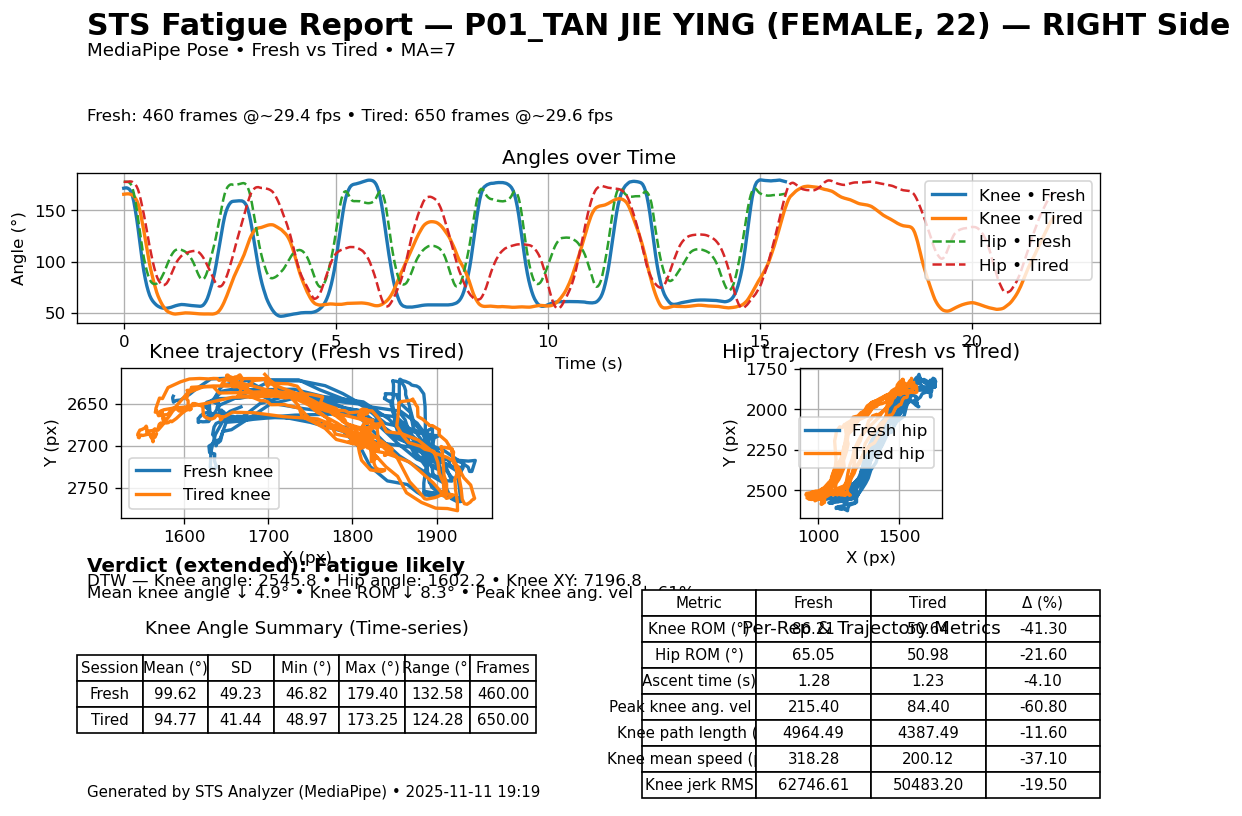


Report saved:
 - outputs\P01_TAN JIE YING\P01_TAN JIE YING_RIGHT_STS_report_20251111-191905.png
 - outputs\P01_TAN JIE YING\P01_TAN JIE YING_RIGHT_STS_report_20251111-191905.pdf

===== Copy-ready Summary =====
Participant: P01_TAN JIE YING (FEMALE, 22) — Side: RIGHT
Session Mean (°)    SD Min (°) Max (°) Range (°) Frames
  Fresh    99.62 49.23   46.82  179.40    132.58 460.00
  Tired    94.77 41.44   48.97  173.25    124.28 650.00

Per-rep/Trajectory (Fresh vs Tired, Δ%):
                  Metric    Fresh    Tired  Δ (%)
            Knee ROM (°)    86.21    50.64 -41.30
             Hip ROM (°)    65.05    50.98 -21.60
         Ascent time (s)     1.28     1.23  -4.10
Peak knee ang. vel (°/s)   215.40    84.40 -60.80
   Knee path length (px)  4964.49  4387.49 -11.60
  Knee mean speed (px/s)   318.28   200.12 -37.10
           Knee jerk RMS 62746.61 50483.20 -19.50

Verdict (basic):   Fatigue likely  | Reasons: Mean knee angle ↓ 4.9°, Knee ROM ↓ 8.3°
Verdict (extended): Fatigue likely 

In [12]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams["figure.dpi"] = 120

# ---------- Utilities ----------
def calculate_angle(a, b, c):
    """Angle at point b (degrees) given 2D points a,b,c."""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc)) + 1e-9
    cosine = np.clip(np.dot(ba, bc) / denom, -1.0, 1.0)
    return float(np.degrees(np.arccos(cosine)))

def smooth_ma(x, window=7):
    """Centered moving average with edge padding; returns same length."""
    x = np.asarray(x, float)
    if window <= 1 or window > len(x):
        return x.copy()
    pad = window // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    kernel = np.ones(window) / window
    y = np.convolve(xpad, kernel, mode="valid")
    return y[:len(x)]

def format_df(df, nd=2):
    """Format numbers to fixed decimals; hide NaNs as empty strings."""
    out = df.copy()
    out = out.applymap(
        lambda x: "" if (x is None or (isinstance(x, float) and not np.isfinite(x)))
        else (f"{x:.{nd}f}" if isinstance(x, (float, np.floating, int, np.integer)) else x)
    )
    return out

# ---------- Extraction: angles + XY ----------
def extract_angles_and_xy(video_path, side="RIGHT", ma_window=7):
    """
    Returns df with:
      - time_s, knee_angle(_smooth), hip_angle(_smooth), knee_vel (deg/s)
      - XY in pixels for shoulder/hip/knee/ankle
    """
    video_path = str(video_path)
    mp_pose = mp.solutions.pose

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    idx = mp_pose.PoseLandmark
    if side.upper() == "RIGHT":
        SHO, HIP, KNEE, ANKLE = (
            idx.RIGHT_SHOULDER.value,
            idx.RIGHT_HIP.value,
            idx.RIGHT_KNEE.value,
            idx.RIGHT_ANKLE.value,
        )
    else:
        SHO, HIP, KNEE, ANKLE = (
            idx.LEFT_SHOULDER.value,
            idx.LEFT_HIP.value,
            idx.LEFT_KNEE.value,
            idx.LEFT_ANKLE.value,
        )

    frames, times = [], []
    knee, hip = [], []
    sho_x, sho_y, hip_x, hip_y, kne_x, kne_y, ank_x, ank_y = [], [], [], [], [], [], [], []

    with mp_pose.Pose(static_image_mode=False) as pose:
        f = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            h, w = frame.shape[:2]
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            knee_ang = np.nan
            hip_ang = np.nan
            Sx = Sy = Hx = Hy = Kx = Ky = Ax = Ay = np.nan

            if results.pose_landmarks:
                lm = results.pose_landmarks.landmark
                Sx, Sy = lm[SHO].x * w, lm[SHO].y * h
                Hx, Hy = lm[HIP].x * w, lm[HIP].y * h
                Kx, Ky = lm[KNEE].x * w, lm[KNEE].y * h
                Ax, Ay = lm[ANKLE].x * w, lm[ANKLE].y * h

                shoulder = [lm[SHO].x,  lm[SHO].y]
                hipP     = [lm[HIP].x,  lm[HIP].y]
                kneeP    = [lm[KNEE].x, lm[KNEE].y]
                ankle    = [lm[ANKLE].x,lm[ANKLE].y]
                knee_ang = calculate_angle(hipP, kneeP, ankle)      # hip–knee–ankle
                hip_ang  = calculate_angle(shoulder, hipP, kneeP)   # shoulder–hip–knee

            frames.append(f)
            times.append(f / fps)
            knee.append(knee_ang)
            hip.append(hip_ang)
            sho_x.append(Sx); sho_y.append(Sy)
            hip_x.append(Hx); hip_y.append(Hy)
            kne_x.append(Kx); kne_y.append(Ky)
            ank_x.append(Ax); ank_y.append(Ay)
            f += 1

    cap.release()

    df = pd.DataFrame({
        "frame": frames, "time_s": times,
        "knee_angle": knee, "hip_angle": hip,
        "sho_x": sho_x, "sho_y": sho_y,
        "hip_x": hip_x, "hip_y": hip_y,
        "knee_x": kne_x, "knee_y": kne_y,
        "ankle_x": ank_x, "ankle_y": ank_y
    })

    # interpolate & smooth
    for col in ["knee_angle","hip_angle","sho_x","sho_y","hip_x","hip_y","knee_x","knee_y","ankle_x","ankle_y"]:
        df[col] = pd.Series(df[col]).interpolate(limit_direction="both")

    df["knee_angle_smooth"] = smooth_ma(df["knee_angle"].values, ma_window)
    df["hip_angle_smooth"]  = smooth_ma(df["hip_angle"].values, ma_window)

    # knee angular velocity (deg/s) — FIX: use time vector directly
    t = df["time_s"].values
    df["knee_vel"] = np.gradient(df["knee_angle_smooth"].values, t)

    return df, fps

# ---------- Session stats ----------
def quick_stats(df):
    s = pd.Series(df["knee_angle_smooth"]).dropna().values
    if len(s) == 0:
        return {"mean": np.nan, "std": np.nan, "min": np.nan, "max": np.nan, "range": np.nan, "n_frames": len(df)}
    return {
        "mean": float(np.mean(s)),
        "std": float(np.std(s, ddof=1)) if len(s) > 1 else 0.0,
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "range": float(np.max(s) - np.min(s)),
        "n_frames": int(len(s))
    }

# ---------- Rep segmentation (with fallback) ----------
def segment_reps(df, fps, min_separation_s=1.0):
    ang = df["knee_angle_smooth"].values
    vel = df["knee_vel"].values

    # primary: zero-crossings (neg->pos)
    sign = np.sign(vel)
    minima = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0] + 1

    # refractory
    keep = []
    last = -10**9
    min_sep = int(min_separation_s * fps)
    for i in minima:
        if i - last >= min_sep:
            keep.append(i); last = i
    mins = np.array(keep, dtype=int)

    # fallback: local-min window if not enough
    if len(mins) < 2:
        w = max(int(0.35 * fps), 3)  # ~350 ms neighborhood
        cand = []
        for i in range(w, len(ang)-w):
            neighborhood = ang[i-w:i+w+1]
            if np.argmin(neighborhood) == w:
                cand.append(i)
        keep = []
        last = -10**9
        for i in cand:
            if i - last >= min_sep:
                keep.append(i); last = i
        mins = np.array(keep, dtype=int)

    reps = []
    for i in range(len(mins)-1):
        lo, hi = mins[i], mins[i+1]
        if hi <= lo+2:
            continue
        seg = ang[lo:hi]
        max_idx = lo + int(np.argmax(seg))
        reps.append((lo, mins[i], max_idx, hi))
    return reps

def per_rep_features(df, reps):
    """Return per-rep DataFrame with knee/hip ROM, ascent/descent times, peak knee angular velocity."""
    feats = []
    t = df["time_s"].values
    k = df["knee_angle_smooth"].values
    h = df["hip_angle_smooth"].values
    v = df["knee_vel"].values
    for (start_i, min_i, max_i, end_i) in reps:
        kmin, kmax = k[min_i], k[max_i]
        ROM_knee = kmax - kmin
        ROM_hip  = (h[max_i] - h[min_i]) if np.isfinite(h[max_i]) and np.isfinite(h[min_i]) else np.nan
        ascent_t  = t[max_i] - t[min_i]
        descent_t = t[end_i] - t[max_i]
        peak_vel  = np.nanmax(np.abs(v[min_i:end_i])) if end_i > min_i else np.nan
        feats.append({
            "rep_start_s": float(t[start_i]), "rep_end_s": float(t[end_i]),
            "knee_ROM": float(ROM_knee), "hip_ROM": float(ROM_hip),
            "ascent_time_s": float(ascent_t), "descent_time_s": float(descent_t),
            "knee_peak_vel_deg_s": float(peak_vel)
        })
    return pd.DataFrame(feats)

# ---------- Trajectory metrics & DTW ----------
def path_length(x, y):
    dx = np.diff(x); dy = np.diff(y)
    return float(np.nansum(np.sqrt(dx*dx + dy*dy)))

def mean_speed(x, y, t):
    dx = np.diff(x); dy = np.diff(y); dt = np.diff(t)
    step_d = np.sqrt(dx*dx + dy*dy)
    step_v = np.divide(step_d, np.clip(dt, 1e-6, None))
    return float(np.nanmean(step_v))

def smoothness_jerk(x, y, t):
    vx = np.gradient(x, t); vy = np.gradient(y, t)
    ax = np.gradient(vx, t); ay = np.gradient(vy, t)
    jx = np.gradient(ax, t); jy = np.gradient(ay, t)
    jerk_mag = np.sqrt(jx*jx + jy*jy)
    return float(np.nanmean(jerk_mag))

def trajectory_summary(df):
    t = df["time_s"].values
    out = {}
    for joint in ["knee", "hip"]:
        x = df[f"{joint}_x"].values
        y = df[f"{joint}_y"].values
        out[f"{joint}_path_len_px"]     = path_length(x, y)
        out[f"{joint}_mean_speed_px_s"] = mean_speed(x, y, t)
        out[f"{joint}_jerk_rms"]        = smoothness_jerk(x, y, t)
    return out

def resample_series(x, n=300):
    x = np.asarray(x, float)
    xp = np.linspace(0, 1, len(x))
    xq = np.linspace(0, 1, n)
    return np.interp(xq, xp, x)

def dtw_distance(a, b):
    A, B = np.asarray(a), np.asarray(b)
    n, m = len(A), len(B)
    D = np.full((n+1, m+1), np.inf); D[0,0] = 0.0
    for i in range(1, n+1):
        ai = A[i-1]
        for j in range(1, m+1):
            cost = abs(ai - B[j-1])
            D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])
    return float(D[n,m])

def dtw_compare_angles(df_fresh, df_tired, n=300):
    af = resample_series(df_fresh["knee_angle_smooth"].values, n)
    at = resample_series(df_tired["knee_angle_smooth"].values, n)
    hf = resample_series(df_fresh["hip_angle_smooth"].values, n)
    ht = resample_series(df_tired["hip_angle_smooth"].values, n)
    return {
        "dtw_knee_angle": dtw_distance(af, at),
        "dtw_hip_angle":  dtw_distance(hf, ht),
    }

def dtw_compare_knee_xy(df_fresh, df_tired, n=300):
    xf = resample_series(df_fresh["knee_x"].values, n)
    yf = resample_series(df_fresh["knee_y"].values, n)
    xt = resample_series(df_tired["knee_x"].values, n)
    yt = resample_series(df_tired["knee_y"].values, n)
    mf = np.sqrt((xf - np.nanmean(xf))**2 + (yf - np.nanmean(yf))**2)
    mt = np.sqrt((xt - np.nanmean(xt))**2 + (yt - np.nanmean(yt))**2)
    return {"dtw_knee_xy": dtw_distance(mf, mt)}

# ---------- Fatigue rules ----------
def simple_fatigue_flag(stats_fresh, stats_tired, mean_drop_thr=3.0, range_drop_thr=5.0):
    mean_drop  = stats_fresh["mean"]  - stats_tired["mean"]
    range_drop = stats_fresh["range"] - stats_tired["range"]
    flags = []
    if mean_drop > mean_drop_thr:
        flags.append(f"Mean knee angle ↓ {mean_drop:.1f}°")
    if range_drop > range_drop_thr:
        flags.append(f"Knee ROM ↓ {range_drop:.1f}°")
    verdict = "Fatigue likely" if flags else "No strong fatigue signal"
    return verdict, flags

def fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t,
                          mean_drop_thr=3.0, range_drop_thr=5.0,
                          vel_drop_pct=15.0, asc_increase_pct=15.0):
    flags = []
    mean_drop  = stats_f["mean"]  - stats_t["mean"]
    range_drop = stats_f["range"] - stats_t["range"]
    if mean_drop > mean_drop_thr:
        flags.append(f"Mean knee angle ↓ {mean_drop:.1f}°")
    if range_drop > range_drop_thr:
        flags.append(f"Knee ROM ↓ {range_drop:.1f}°")

    if np.isfinite(agg_f.get("knee_peak_vel_deg_s", np.nan)) and np.isfinite(agg_t.get("knee_peak_vel_deg_s", np.nan)):
        v_drop = 100.0 * (agg_f["knee_peak_vel_deg_s"] - agg_t["knee_peak_vel_deg_s"]) / max(agg_f["knee_peak_vel_deg_s"], 1e-6)
        if v_drop >= vel_drop_pct:
            flags.append(f"Peak knee ang. vel ↓ {v_drop:.0f}%")

    if np.isfinite(agg_f.get("ascent_time_s", np.nan)) and np.isfinite(agg_t.get("ascent_time_s", np.nan)):
        asc_up = 100.0 * (agg_t["ascent_time_s"] - agg_f["ascent_time_s"]) / max(agg_f["ascent_time_s"], 1e-6)
        if asc_up >= asc_increase_pct:
            flags.append(f"Ascent time ↑ {asc_up:.0f}%")

    verdict = "Fatigue likely" if flags else "No strong fatigue signal"
    return verdict, flags

# ---------- Plot helper ----------
def plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(df_fresh[f"{joint}_x"], df_fresh[f"{joint}_y"], label=f"Fresh {joint}", linewidth=2)
    ax.plot(df_tired[f"{joint}_x"], df_tired[f"{joint}_y"], label=f"Tired {joint}", linewidth=2)
    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True); ax.legend(loc="best")
    ax.set_xlabel("X (px)"); ax.set_ylabel("Y (px)")
    ax.set_title(title or f"{joint.capitalize()} trajectory (Fresh vs Tired)")

def save_csv(df, video_path, tag):
    out = Path(video_path).with_suffix("")
    out_csv = Path(f"{out}_{tag}_angles_xy.csv")
    df.to_csv(out_csv, index=False)
    return out_csv

# =========================
# MAIN CONFIG — edit here
# =========================
fresh_video = r"C:\Users\tanjy\Fresh Squat.mov"
tired_video = r"C:\Users\tanjy\Tired Squat.mov"

SIDE = "RIGHT"         # or "LEFT"
MA_WINDOW = 7          # 5–11 is typical

p_name   = "P01_TAN JIE YING"
p_age    = "22"
p_gender = "FEMALE"

# =========================
# RUN PIPELINE
# =========================
df_fresh, fps_f = extract_angles_and_xy(fresh_video, SIDE, MA_WINDOW)
df_tired, fps_t = extract_angles_and_xy(tired_video, SIDE, MA_WINDOW)

csv_f = save_csv(df_fresh, fresh_video, "fresh")
csv_t = save_csv(df_tired, tired_video, "tired")
print(f"Saved CSVs:\n - {csv_f}\n - {csv_t}")

stats_f = quick_stats(df_fresh)
stats_t = quick_stats(df_tired)

# reps & per-rep
reps_f = segment_reps(df_fresh, fps_f, min_separation_s=1.0)
reps_t = segment_reps(df_tired, fps_t, min_separation_s=1.0)
perrep_f = per_rep_features(df_fresh, reps_f) if len(reps_f) else pd.DataFrame()
perrep_t = per_rep_features(df_tired, reps_t) if len(reps_t) else pd.DataFrame()

# Aggregates (with fallback to session ROM if reps missing)
def agg_or_fallback(perrep_df, df_ts):
    if perrep_df.empty:
        agg = {
            "knee_ROM": float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5)),
            "hip_ROM":  float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5)),
            "ascent_time_s": np.nan,
            "descent_time_s": np.nan,
            "knee_peak_vel_deg_s": float(np.nanmax(np.abs(df_ts["knee_vel"])))
        }
    else:
        agg = perrep_df.mean(numeric_only=True).to_dict()
        if not np.isfinite(agg.get("knee_ROM", np.nan)):
            agg["knee_ROM"] = float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5))
        if not np.isfinite(agg.get("hip_ROM", np.nan)):
            agg["hip_ROM"]  = float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5))
    return agg

agg_f = agg_or_fallback(perrep_f, df_fresh)
agg_t = agg_or_fallback(perrep_t, df_tired)

# Trajectory metrics
traj_f = trajectory_summary(df_fresh)
traj_t = trajectory_summary(df_tired)

# DTW (angles + knee XY)
dtw_angles = dtw_compare_angles(df_fresh, df_tired, n=300)
dtw_kxy    = dtw_compare_knee_xy(df_fresh, df_tired, n=300)

# Verdicts
verdict_basic, reasons_basic = simple_fatigue_flag(stats_f, stats_t)
verdict_ext, reasons_ext     = fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t)

# =========================
# REPORT (1-page)
# =========================
def _fmt(x, nd=2):
    return "" if (x is None or (isinstance(x,float) and not np.isfinite(x))) else round(float(x), nd)
def _pct(f, t):
    if f is None or t is None or not np.isfinite(f) or not np.isfinite(t):
        return ""
    return round(100.0 * (t - f) / max(abs(f), 1e-6), 1)

# Time-series summary table
summary_df = pd.DataFrame([
    {"Session": "Fresh", "Mean (°)": round(stats_f["mean"], 2), "SD": round(stats_f["std"],2),
     "Min (°)": round(stats_f["min"],2), "Max (°)": round(stats_f["max"],2),
     "Range (°)": round(stats_f["range"],2), "Frames": stats_f["n_frames"]},
    {"Session": "Tired", "Mean (°)": round(stats_t["mean"], 2), "SD": round(stats_t["std"],2),
     "Min (°)": round(stats_t["min"],2), "Max (°)": round(stats_t["max"],2),
     "Range (°)": round(stats_t["range"],2), "Frames": stats_t["n_frames"]}
]).fillna("")
summary_df_fmt = format_df(summary_df, 2)

# Per-rep/trajectory comparisons
rows = []
rows.append(["Knee ROM (°)",            _fmt(agg_f.get("knee_ROM")),           _fmt(agg_t.get("knee_ROM")),           _pct(agg_f.get("knee_ROM"),           agg_t.get("knee_ROM"))])
rows.append(["Hip ROM (°)",             _fmt(agg_f.get("hip_ROM")),            _fmt(agg_t.get("hip_ROM")),            _pct(agg_f.get("hip_ROM"),            agg_t.get("hip_ROM"))])
rows.append(["Ascent time (s)",         _fmt(agg_f.get("ascent_time_s")),      _fmt(agg_t.get("ascent_time_s")),      _pct(agg_f.get("ascent_time_s"),      agg_t.get("ascent_time_s"))])
rows.append(["Peak knee ang. vel (°/s)",_fmt(agg_f.get("knee_peak_vel_deg_s")),_fmt(agg_t.get("knee_peak_vel_deg_s")),_pct(agg_f.get("knee_peak_vel_deg_s"),agg_t.get("knee_peak_vel_deg_s"))])
rows.append(["Knee path length (px)",   _fmt(traj_f.get("knee_path_len_px")),  _fmt(traj_t.get("knee_path_len_px")),  _pct(traj_f.get("knee_path_len_px"),  traj_t.get("knee_path_len_px"))])
rows.append(["Knee mean speed (px/s)",  _fmt(traj_f.get("knee_mean_speed_px_s")),_fmt(traj_t.get("knee_mean_speed_px_s")),_pct(traj_f.get("knee_mean_speed_px_s"),traj_t.get("knee_mean_speed_px_s"))])
rows.append(["Knee jerk RMS",           _fmt(traj_f.get("knee_jerk_rms")),     _fmt(traj_t.get("knee_jerk_rms")),     _pct(traj_f.get("knee_jerk_rms"),     traj_t.get("knee_jerk_rms"))])

derived_df = pd.DataFrame(rows, columns=["Metric", "Fresh", "Tired", "Δ (%)"])
derived_df = derived_df.replace("", np.nan).dropna(how="all").fillna("")
derived_df_fmt = format_df(derived_df, 2)

# Figure grid
fig = plt.figure(figsize=(11, 8.5))
gs = fig.add_gridspec(
    nrows=7, ncols=4,
    height_ratios=[0.8, 0.25, 2.4, 2.4, 0.6, 1.6, 0.25],
    hspace=0.6, wspace=0.6
)

# Title
ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
title = f"STS Fatigue Report — {p_name} ({p_gender}, {p_age}) — {SIDE} Side"
subtitle = f"MediaPipe Pose • Fresh vs Tired • MA={MA_WINDOW}"
ax_title.text(0.01, 0.68, title, fontsize=18, weight="bold", ha="left")
ax_title.text(0.01, 0.25, subtitle, fontsize=11, ha="left")

# Meta
ax_meta = fig.add_subplot(gs[1, :]); ax_meta.axis("off")
ax_meta.text(0.01, 0.55, f"Fresh: {stats_f['n_frames']} frames @~{fps_f:.1f} fps • Tired: {stats_t['n_frames']} frames @~{fps_t:.1f} fps", fontsize=10, ha="left")

# Time-series (knee + hip)
ax_ts = fig.add_subplot(gs[2, :])
ax_ts.plot(df_fresh["time_s"], df_fresh["knee_angle_smooth"], label="Knee • Fresh", linewidth=2)
ax_ts.plot(df_tired["time_s"], df_tired["knee_angle_smooth"], label="Knee • Tired", linewidth=2)
ax_ts.plot(df_fresh["time_s"], df_fresh["hip_angle_smooth"],  label="Hip • Fresh",  linewidth=1.5, linestyle="--")
ax_ts.plot(df_tired["time_s"], df_tired["hip_angle_smooth"],  label="Hip • Tired",   linewidth=1.5, linestyle="--")
ax_ts.set_xlabel("Time (s)"); ax_ts.set_ylabel("Angle (°)")
ax_ts.set_title("Angles over Time"); ax_ts.grid(True); ax_ts.legend(loc="upper right")

# XY trajectories
ax_knee_xy = fig.add_subplot(gs[3, 0:2])
plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=ax_knee_xy, title="Knee trajectory (Fresh vs Tired)")
ax_hip_xy = fig.add_subplot(gs[3, 2:4])
plot_xy_trajectories(df_fresh, df_tired, joint="hip", ax=ax_hip_xy, title="Hip trajectory (Fresh vs Tired)")

# Verdict + DTW
ax_ver = fig.add_subplot(gs[4, :]); ax_ver.axis("off")
reasons_text = " • ".join(reasons_ext) if reasons_ext else "No thresholds exceeded."
ax_ver.text(0.01, 0.75, f"Verdict (extended): {verdict_ext}", fontsize=12, weight="bold", ha="left")
ax_ver.text(0.01, 0.38, f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} • Hip angle: {dtw_angles['dtw_hip_angle']:.1f} • Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}",
            fontsize=10, ha="left")
ax_ver.text(0.01, 0.05, reasons_text, fontsize=10, ha="left")

# Tables
ax_tbl1 = fig.add_subplot(gs[5, 0:2]); ax_tbl1.axis("off")
tbl1 = ax_tbl1.table(cellText=summary_df_fmt.values, colLabels=summary_df_fmt.columns, loc="center", cellLoc="center")
tbl1.auto_set_font_size(False); tbl1.set_fontsize(9); tbl1.scale(1.0, 1.3)
ax_tbl1.set_title("Knee Angle Summary (Time-series)", fontsize=11, pad=6)

ax_tbl2 = fig.add_subplot(gs[5, 2:4]); ax_tbl2.axis("off")
tbl2 = ax_tbl2.table(cellText=derived_df_fmt.values, colLabels=derived_df_fmt.columns, loc="center", cellLoc="center")
tbl2.auto_set_font_size(False); tbl2.set_fontsize(9); tbl2.scale(1.0, 1.3)
ax_tbl2.set_title("Per-Rep & Trajectory Metrics", fontsize=11, pad=6)

# Footer
ax_foot = fig.add_subplot(gs[6, :]); ax_foot.axis("off")
ax_foot.text(0.01, 0.5, "Generated by STS Analyzer (MediaPipe) • " + pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"), fontsize=9, ha="left")

plt.show()

# Save
report_dir = Path("outputs") / p_name
report_dir.mkdir(parents=True, exist_ok=True)
stamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
png_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.png"
pdf_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.pdf"
fig.savefig(png_path, dpi=220, bbox_inches="tight")
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")

print(f"\nReport saved:\n - {png_path}\n - {pdf_path}")

# Console summary (formatted, no scientific notation)
print("\n===== Copy-ready Summary =====")
print(f"Participant: {p_name} ({p_gender}, {p_age}) — Side: {SIDE}")
print(summary_df_fmt.to_string(index=False))
print("\nPer-rep/Trajectory (Fresh vs Tired, Δ%):")
print(derived_df_fmt.to_string(index=False))
print(f"\nVerdict (basic):   {verdict_basic}  | Reasons: {', '.join(reasons_basic) if reasons_basic else '-'}")
print(f"Verdict (extended): {verdict_ext}  | Reasons: {', '.join(reasons_ext) if reasons_ext else '-'}")
print(f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} | Hip angle: {dtw_angles['dtw_hip_angle']:.1f} | Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}")